In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import deque, defaultdict
from linearApprox import *
from collections import deque

In [ ]:
def run_n_step_sarsa_linear(
    initialEdges, goalEdges, totalSteps, nLookahead,
    epsilon, gamma, alpha, pGen, pSwap, maxAge,
    edr_window_size=100, convergence_epsilon=0.001, plot=False,
    softmax=False, temperature=1.0, temperature_decay=1.0,
    reward_mode="basic", reward_alpha=1, reward_epsilon=0.001
):
    def select_action(state, temperature, epsilon, softmax):
        features = featurize_state(state, goal_order=goalEdges)
        possible_actions = getPossibleActions(state[0], goalEdges)

        if softmax:
            q_vals = [Q.get_q_value(features, a) for a in possible_actions]
            probs = softmax_probs(q_vals, temperature)
            return random.choices(possible_actions, weights=probs)[0]
        else:
            return random.choice(possible_actions) if random.random() < epsilon else max(
                possible_actions, key=lambda a: Q.get_q_value(features, a)
            )

    feature_size = len(initialEdges) + len(goalEdges)
    Q = LinearQApproximator(feature_size=feature_size)
    q_value_diffs = []

    goal_success_queues = {goal: deque(maxlen=edr_window_size) for goal in goalEdges}
    raw_state = [(edge, -1) for edge in initialEdges]
    rolling_edrs = {goal: 0.0 for goal in goalEdges}
    current_state = get_augmented_state(raw_state, rolling_edrs, goal_order=goalEdges)

    action = select_action(current_state, temperature, epsilon, softmax)

    state_buffer = deque([current_state], maxlen=nLookahead + 1)
    action_buffer = deque([action], maxlen=nLookahead + 1)
    reward_buffer = deque([], maxlen=nLookahead)

    for t in range(totalSteps):
        prev_state = state_buffer[-1]
        prev_action = action_buffer[-1]

        next_state = performAction(prev_action, prev_state)
        next_state = ageEntanglements(next_state, maxAge)
        next_state = generateEntanglement(next_state, pGen)

        consumed_edges, goal = prev_action
        success = False
        if goal is not None and consumed_edges:
            success_prob = pSwap ** (len(consumed_edges) - 1)
            success = random.random() < success_prob

        reward = compute_reward(
            action=prev_action,
            goal_success_queues=goal_success_queues,
            total_timesteps=t + 1,
            pSwap=pSwap,
            mode=reward_mode,
            alpha=reward_alpha,
            epsilon=reward_epsilon,
            success=success
        )
        
        reward_buffer.append(reward)

        edr_snapshot = {
            g: sum(goal_success_queues[g]) / max(1, len(goal_success_queues[g]))
            for g in goalEdges
        }
        next_state = get_augmented_state(next_state[0], edr_snapshot, goal_order=goalEdges)
        state_buffer.append(next_state)
        next_action = select_action(next_state, temperature, epsilon, softmax)
        action_buffer.append(next_action)

        if t >= nLookahead:
            G = sum((gamma ** i) * reward_buffer[i] for i in range(nLookahead))
            s_tau = state_buffer[0]
            a_tau = action_buffer[0]
            s_next = state_buffer[-1]
            a_next = action_buffer[-1]
            G += (gamma ** nLookahead) * Q.get_q_value(featurize_state(s_next, goalEdges), a_next)
            features_tau = featurize_state(s_tau, goal_order=goalEdges)
            current_q = Q.get_q_value(features_tau, a_tau)
            Q.update(features_tau, a_tau, G, alpha)
            q_value_diffs.append(abs(G - current_q))

        if softmax and temperature_decay < 1.0 and t % 10000 == 0:
            temperature = max(0.1, temperature * temperature_decay)

    # Final backup steps
    T = len(reward_buffer)
    for t_rem in range(T):
        n = T - t_rem
        G = sum((gamma ** i) * reward_buffer[t_rem + i] for i in range(n))
        s_tau = state_buffer[t_rem]
        a_tau = action_buffer[t_rem]
        s_next = state_buffer[-1]
        a_next = action_buffer[-1]
        G += (gamma ** n) * Q.get_q_value(featurize_state(s_next, goal_order=goalEdges), a_next)

        features_tau = featurize_state(s_tau, goal_order=goalEdges)
        current_q = Q.get_q_value(features_tau, a_tau)
        Q.update(features_tau, a_tau, G, alpha)
        q_value_diffs.append(abs(G - current_q))


    return q_value_diffs, Q, edr_snapshot, 


def train_sarsa_linear_policy(
    edges, goal_edges, p_swap, p_gen, max_age,
    seed=0, **kwargs
):
    random.seed(seed)
    np.random.seed(seed)

    # Extract hyperparameters with defaults
    alpha = kwargs.get("alpha", 0.1)
    gamma = kwargs.get("gamma", 0.99)
    epsilon = kwargs.get("epsilon", 0.05)
    totalSteps = kwargs.get("totalSteps", 10000)
    nLookahead = kwargs.get("nLookahead", 5)
    edr_window_size = kwargs.get("edr_window_size", 100)
    softmax = kwargs.get("softmax", False)
    temperature = kwargs.get("temperature", 1.0)
    temperature_decay = kwargs.get("temperature_decay", 1.0)

    reward_mode = 'basic'
    reward_alpha = kwargs.get("reward_alpha", 1)
    reward_epsilon = kwargs.get("reward_epsilon", 0.001)

    # Train with n-step SARSA
    q_value_diffs, Q, _ = run_n_step_sarsa_linear(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        epsilon=epsilon,
        gamma=gamma,
        alpha=alpha,
        pGen=p_gen,
        pSwap=p_swap,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        softmax=softmax,
        temperature=temperature,
        temperature_decay=temperature_decay,
        reward_mode=reward_mode,
        reward_alpha=reward_alpha,
        reward_epsilon=reward_epsilon,
    )
    return Q




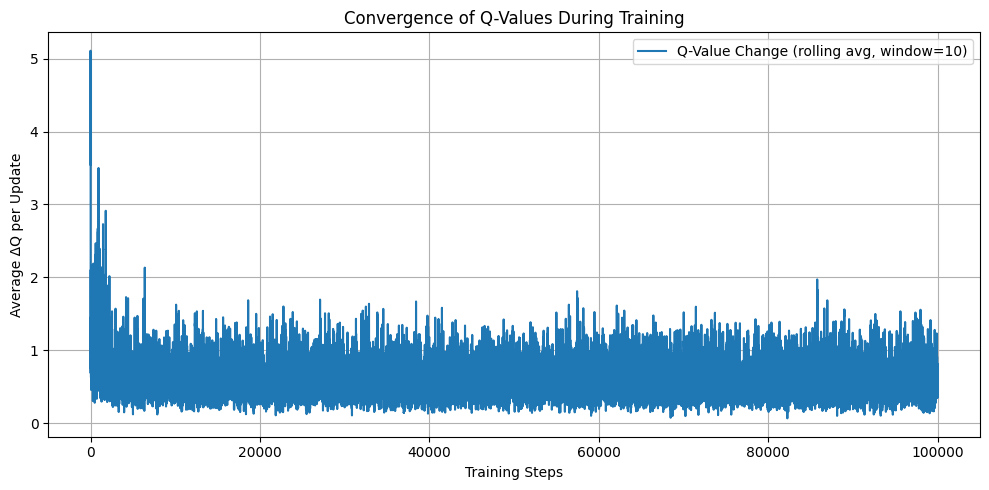

temperature 5, temp decay 0.995, nlookahead5, steps 100000


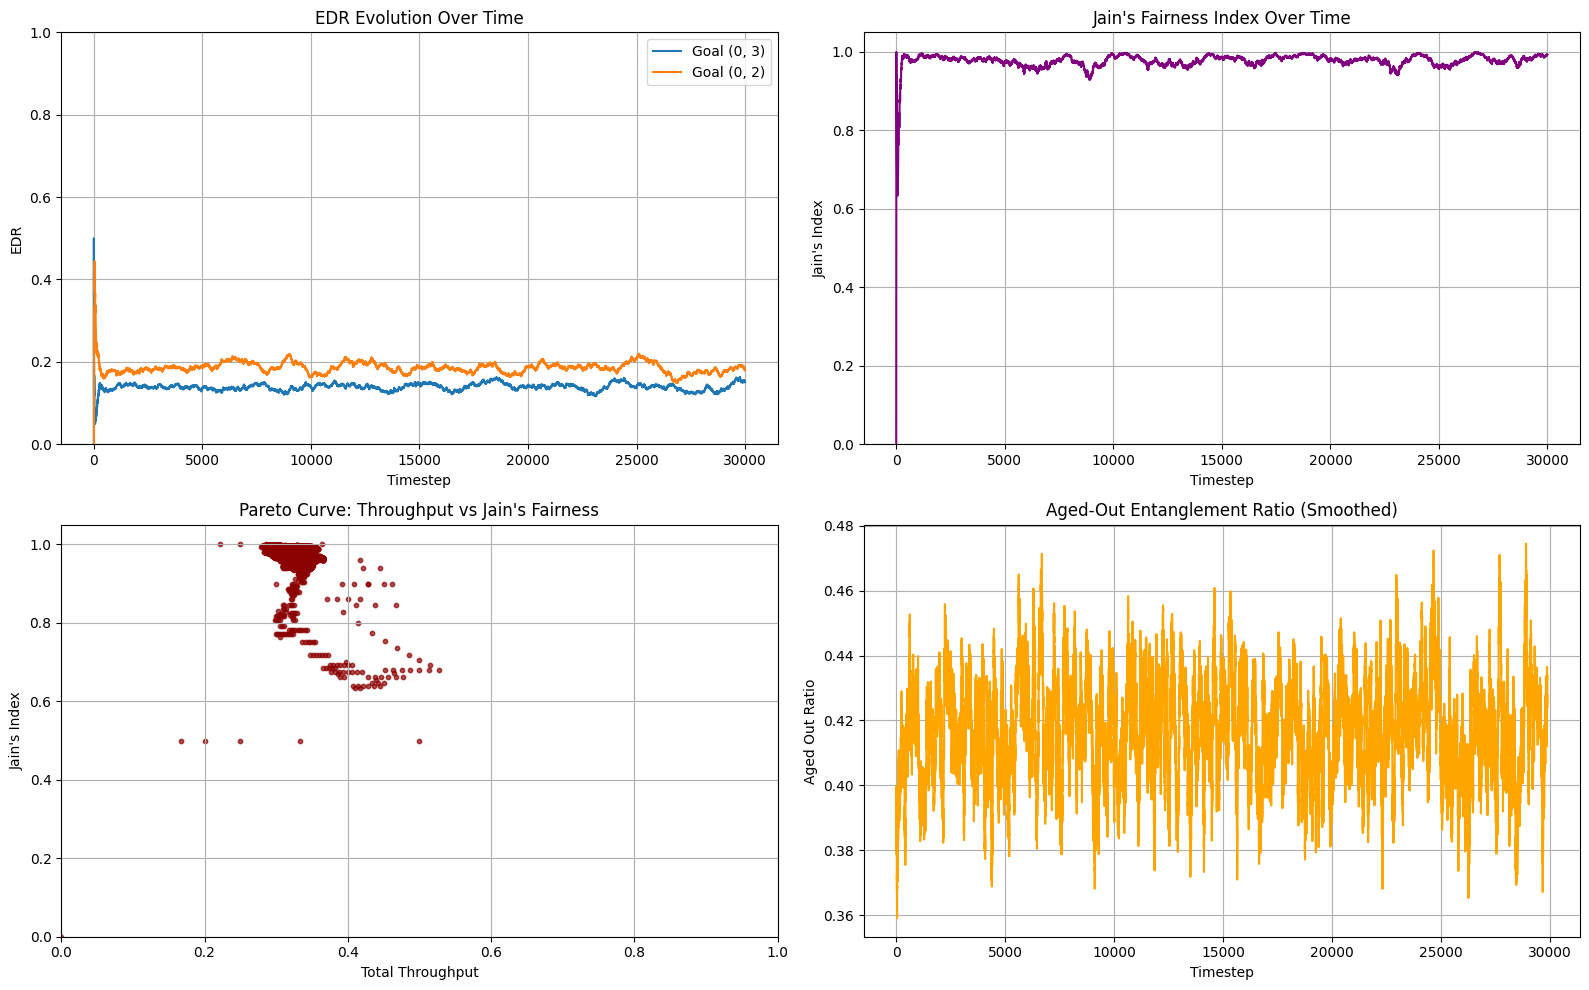

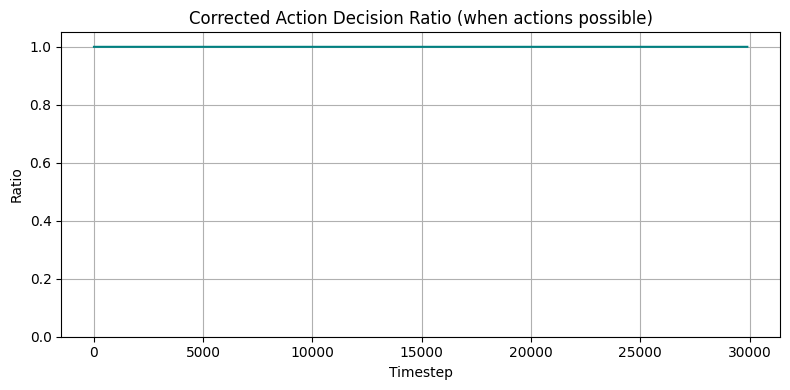

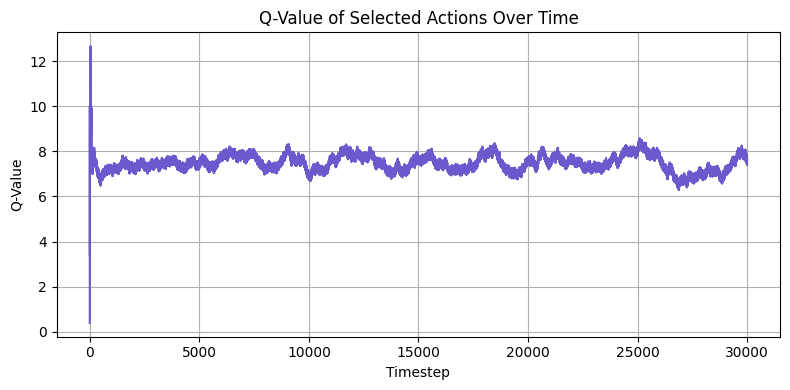

<Figure size 640x480 with 0 Axes>


=== Mean EDRs After Burn-In ===
Goal (0, 3): 0.1391
Goal (0, 2): 0.1860
Mean Jain's Index (after burn-in): 0.9782


({(0, 3): 4173, (0, 2): 5557},
 30000,
 {(0, 3): [0.0,
   0.5,
   0.3333333333333333,
   0.25,
   0.2,
   0.16666666666666666,
   0.14285714285714285,
   0.125,
   0.1111111111111111,
   0.2,
   0.18181818181818182,
   0.16666666666666666,
   0.15384615384615385,
   0.14285714285714285,
   0.13333333333333333,
   0.125,
   0.11764705882352941,
   0.16666666666666666,
   0.15789473684210525,
   0.15,
   0.14285714285714285,
   0.13636363636363635,
   0.13043478260869565,
   0.125,
   0.12,
   0.11538461538461539,
   0.1111111111111111,
   0.10714285714285714,
   0.10344827586206896,
   0.1,
   0.0967741935483871,
   0.09375,
   0.09090909090909091,
   0.08823529411764706,
   0.08571428571428572,
   0.08333333333333333,
   0.08108108108108109,
   0.07894736842105263,
   0.07692307692307693,
   0.075,
   0.07317073170731707,
   0.07142857142857142,
   0.06976744186046512,
   0.06818181818181818,
   0.06666666666666667,
   0.06521739130434782,
   0.06382978723404255,
   0.0625,
   0.061224

In [8]:
edges = [(0,1),(1,2), (2,3)]
goal_edges = [(0, 3), (0,2)]
pSwap = 0.7
pGen = 0.7
maxAge = 2
max_steps = 100000
num_episodes = 20
nLookahead = 5
epsilon = 0.05
gamma = 0.99
alpha = 0.1
edr_window_size=1000
temperature = 5
temperature_decay = 0.995
seed = 10
random.seed(seed)
np.random.seed(seed)
q_diffs, Q, _ = run_n_step_sarsa_linear(
    initialEdges=edges,
    goalEdges=goal_edges,
    totalSteps=max_steps,
    nLookahead=nLookahead,
    epsilon=epsilon,
    gamma=gamma,
    alpha=alpha,
    pGen=pGen,
    pSwap=pSwap,
    maxAge=maxAge,
    edr_window_size=edr_window_size,
    plot=False,
    softmax=False, 
    temperature=temperature, 
    temperature_decay=temperature_decay
)
plot_q_value_convergence(q_diffs)

print(f'temperature {temperature}, temp decay {temperature_decay}, nlookahead{nLookahead}, steps {max_steps}')
simulate_policy(Q_table=Q, edges=edges, goal_edges=goal_edges,
                p_swap=pSwap, p_gen=pGen, max_age=maxAge,
                num_steps=30000, edr_window_size=1000, plot=True)


In [ ]:
def compare_nstep_sarsa_across_nlookahead(
    policy_name,
    policy_train_fn,
    n_lookahead_values,
    edges,
    goal_edges,
    p_gen,
    p_swap,
    max_age,
    train_kwargs={},
    validate_kwargs={},
    plot=True,
    num_runs=5,
    num_steps=10000,
    num_simulations=10
):
    all_results = {}

    for n in n_lookahead_values:
        print(f"\n=== Evaluating {policy_name} for nLookahead = {n} ===")

        results = run_policy_experiments(
            train_policy_fn=policy_train_fn,
            policy_name=f"{policy_name} (n={n})",
            edges=edges,
            goal_edges=goal_edges,
            p_gen=p_gen,
            p_swap=p_swap,
            max_age=max_age,
            num_runs=num_runs,
            num_steps=num_steps,
            num_simulations=num_simulations,
            train_kwargs={**train_kwargs, "nLookahead": n},
            validate_kwargs=validate_kwargs,
            plot=False
        )
        all_results[n] = results

    if plot:
        fig, axs = plt.subplots(2, 3, figsize=(36, 12))
        axs = axs.flatten()
        color_map = plt.get_cmap("tab10")

        # --- Jain's Fairness Plot ---
        for i, n in enumerate(n_lookahead_values):
            jains = all_results[n]['jains']
            axs[0].scatter([n] * len(jains), jains, color=color_map(i), alpha=0.6)
            mean_jain = np.mean(jains)
            axs[0].plot(n, mean_jain, marker='x', markersize=12, color='black')
        axs[0].set_title("Jain's Fairness vs nLookahead")
        axs[0].set_xlabel("nLookahead")
        axs[0].set_ylabel("Jain's Index")
        axs[0].set_ylim(0, 1.05)
        axs[0].grid(True)

        # --- Pareto curve: Throughput vs Jain ---
        for i, n in enumerate(n_lookahead_values):
            jains = all_results[n]['jains']
            throughputs = [sum(all_results[n]['edrs'][goal][run_i] for goal in goal_edges) for run_i in range(num_runs)]
            axs[1].scatter(throughputs, jains, color=color_map(i), label=f"n={n}", alpha=0.7)
            avg_tp = np.mean(throughputs)
            avg_jain = np.mean(jains)
            axs[1].plot(avg_tp, avg_jain, marker='x', markersize=10, color='black')

        axs[1].set_title("Pareto Curve: Throughput vs Jain's Index")
        axs[1].set_xlabel("Total Throughput")
        axs[1].set_ylabel("Jain's Index")
        axs[1].set_xlim(0, 1.05)
        axs[1].set_ylim(0, 1.05)
        axs[1].legend()
        axs[1].grid(True)

        # --- Final EDR per Goal ---
        for goal_i, goal in enumerate(goal_edges):
            for i, n in enumerate(n_lookahead_values):
                y_vals = all_results[n]['edrs'][goal]
                axs[2].scatter([n] * len(y_vals), y_vals, label=f"{goal}" if i == 0 else "", alpha=0.6, s=30, color=color_map(goal_i))

            mean_y = [np.mean(all_results[n]['edrs'][goal]) for n in n_lookahead_values]
            axs[2].plot(n_lookahead_values, mean_y, linestyle='--', linewidth=2, color=color_map(goal_i))

        axs[2].set_title("Final EDR per Goal vs nLookahead")
        axs[2].set_xlabel("nLookahead")
        axs[2].set_ylabel("EDR")
        axs[2].set_ylim(0, 1)
        axs[2].legend(fontsize=9)
        axs[2].grid(True)

        # --- EDT per Goal ---
        for goal_i, goal in enumerate(goal_edges):
            for i, n in enumerate(n_lookahead_values):
                y_vals = all_results[n]['edts'][goal]
                axs[3].scatter([n] * len(y_vals), y_vals, label=f"{goal}" if i == 0 else "", alpha=0.6, s=30, color=color_map(goal_i))

            mean_y = [np.mean(all_results[n]['edts'][goal]) for n in n_lookahead_values]
            axs[3].plot(n_lookahead_values, mean_y, linestyle='--', linewidth=2, color=color_map(goal_i))

        axs[3].set_title("Expected Delivery Time per Goal")
        axs[3].set_xlabel("nLookahead")
        axs[3].set_ylabel("EDT (1 / EDR)")
        axs[3].set_ylim(0, 100)
        axs[3].legend(fontsize=9)
        axs[3].grid(True)

        # --- Aged-Out & Action Ratio ---
        for i, n in enumerate(n_lookahead_values):
            all_aged = all_results[n]['aged_out_histories']
            all_actions = all_results[n]['action_ratio_histories']

            aged_vals = [np.mean(sim[-1000:]) for run in all_aged for sim in run]
            action_vals = [np.mean(sim[-1000:]) for run in all_actions for sim in run]

            axs[4].scatter([n] * len(aged_vals), aged_vals, color='orange', alpha=0.6, label="Aged-Out" if i == 0 else "")
            axs[4].scatter([n] * len(action_vals), action_vals, color='teal', alpha=0.6, label="Action Ratio" if i == 0 else "")

        axs[4].set_title("Aged-Out & Action Decision Ratio")
        axs[4].set_xlabel("nLookahead")
        axs[4].set_ylabel("Ratio")
        axs[4].set_ylim(0, 1)
        axs[4].legend()
        axs[4].grid(True)

        axs[5].axis('off')

        summary_title = (
            f"{policy_name}: Varying nLookahead\n"
            f"Fixed Params — pGen={p_gen}, pSwap={p_swap}, maxAge={max_age}, "
            f"num_runs={num_runs}, num_steps={num_steps}, num_sims={num_simulations}\n"
            f"Initial Edges={edges}, Goal Edges={goal_edges}"
        )
        plt.suptitle(summary_title, fontsize=20, y=1.05)
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.show()

    return all_results


compare_nstep_sarsa_across_nlookahead(
    policy_name="n-step SARSA",
    policy_train_fn=train_sarsa_linear_policy,
    n_lookahead_values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    edges=[(0,1),(1,2), (2,3), (3, 4)],
    goal_edges=[(0, 3), (0, 4)],
    p_gen=0.7,
    p_swap=0.7,
    max_age=2,
    num_runs=3,
    num_steps=500000,
    num_simulations=3,
    train_kwargs={
        "totalSteps": 100000,
        "alpha": 0.1,
        "gamma": 0.99,
        "epsilon": 0.05,
        "edr_window_size": 1000,
        "softmax": False,
        "temperature": 5.0,
        "temperature_decay": 0.995,
    },
    validate_kwargs={},
    plot=True
)


In [ ]:
edges = [(0,1), (1,2), (2,3), (3, 4)]
goalEdges = [(0, 2), (1, 4)]
pSwap = 0.6
pGen = 0.6
maxAge = 2
totalSteps = 2000000
nLookahead = 3
epsilon = 0.05
gamma = 0.99
alpha = 1
edr_window_size=1000
temperature = 5
temperature_decay = 0.995
alpha_vals = [0.01, 0.5, 1, 1.5, 2]



results = compare_policies_across_alpha(
    policy_name="n-step SARSA",
    policy_train_fn=train_sarsa_linear_policy,
    alpha_values=alpha_vals,
    edges=edges,
    goal_edges=goalEdges,
    p_gen=pGen,
    p_swap=pSwap,
    max_age=maxAge,
    train_kwargs={
        "gamma": 0.99,
        "epsilon": 0.05,
        "totalSteps": 10000,
        "nLookahead": 3,  # You can tune this!
        "edr_window_size": 100,
        "reward_mode": "partial",       # or "alpha_fair", "basic"
        "reward_alpha": 1,
        "reward_epsilon": 0.001,
        "softmax": False,
        "temperature": 3.0,
        "temperature_decay": 0.99
    },
    num_runs=5,
    num_steps=10000,
    num_simulations=10,
    plot=True
)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Setup ===
edges = [(0, 1), (1, 2), (2, 3), (3, 4)]
goal_edges = [(0, 2), (4, 1)]
maxAge = 2

pGen_values = np.linspace(0.1, 1.0, 10)
pSwap_values = np.linspace(0.1, 1.0, 10)

jains_matrix = np.zeros((len(pSwap_values), len(pGen_values)))
throughput_matrix = np.zeros((len(pSwap_values), len(pGen_values)))

# === Run Experiments Over Grid ===
for i, p_swap in enumerate(pSwap_values):
    for j, p_gen in enumerate(pGen_values):
        print(f"Running: pSwap={p_swap:.2f}, pGen={p_gen:.2f}")

        result = run_policy_experiments(
            train_policy_fn=train_sarsa_linear_policy,  # ✅ Use the wrapper
            policy_name=f"n-step SARSA (pSwap={p_swap:.2f}, pGen={p_gen:.2f})",
            edges=edges,
            goal_edges=goalEdges,
            p_gen=p_gen,
            p_swap=p_swap,
            max_age=maxAge,
            num_runs=3,
            num_steps=5000,
            num_simulations=3,
            train_kwargs={
                "alpha": 0.1,
                "gamma": 0.99,
                "epsilon": 0.1,
                "totalSteps": 8000,
                "nLookahead": 3,
                "temperature": 1.0,
                "temperature_decay": 0.98,
                "softmax": False,
                "reward_mode": "partial",        # optional
                "reward_alpha": 0.5,
                "reward_epsilon": 0.001
            },
            plot=False
        )

        # Make sure you're using the correct goal list name
        jains_matrix[i, j] = np.mean(result["jains"])
        throughput_matrix[i, j] = np.mean([
            sum(result["edrs"][goal][run_i] for goal in goalEdges)  # goalEdges here
            for run_i in range(len(result["jains"]))
        ])


# === Plot Heatmaps ===
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Shared color scale
vmin = min(jains_matrix.min(), throughput_matrix.min())
vmax = max(jains_matrix.max(), throughput_matrix.max())

# Jain's Fairness Heatmap
im1 = axs[0].imshow(jains_matrix, cmap='viridis', origin='lower',
                    extent=[pGen_values[0], pGen_values[-1], pSwap_values[0], pSwap_values[-1]],
                    aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title("Jain's Fairness Index")
axs[0].set_xlabel("pGen")
axs[0].set_ylabel("pSwap")

# Throughput Heatmap
im2 = axs[1].imshow(throughput_matrix, cmap='viridis', origin='lower',
                    extent=[pGen_values[0], pGen_values[-1], pSwap_values[0], pSwap_values[-1]],
                    aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title("Total Throughput")
axs[1].set_xlabel("pGen")
axs[1].set_ylabel("pSwap")

# Shared colorbar at the top
cbar_ax = fig.add_axes([0.2, 0.92, 0.6, 0.02])
fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_title("Shared Value Scale")

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()




